# Week 12 Assignment

# PART 1 - Pivoting Data for Fun!

In this exercise, we're going to work with data about condemned buildings in St. Louis.  This data set is in `https://hds5210-data.s3.awsamazon.com/condemn.txt` in CSV format.

## STEP 1: Load and Filter data

For this analysis, we want to look only at a relevent range of years and only years that are in the past.  So, let's first take a look at the data between 1986 and 2014 (inclusive of those dates).

At the end of this step, you should have a data frame loaded from the condemnations file and filtered down to only the data between 1986 and 2014.  Put that into a dataframe named `condemnations`

**Some helpful notes:**
* Use the columns `InspectDate` to filter this date range

In [28]:
%matplotlib inline
import pandas as pd

condemnations = pd.read_csv('https://hds5210-data.s3.amazonaws.com/condemn.txt', low_memory=False)
condemnations.shape

(32586, 40)

In [30]:
import pandas as pd

# Load the dataset
url = 'https://hds5210-data.s3.amazonaws.com/condemn.txt'
condemnations = pd.read_csv(url, low_memory=False)

# Convert 'InspectDate' to datetime format
condemnations['InspectDate'] = pd.to_datetime(condemnations['InspectDate'], errors='coerce')

# Filter the data between 1986 and 2014
condemnations = condemnations[
    (condemnations['InspectDate'] >= '1986-01-01') &
    (condemnations['InspectDate'] <= '2014-12-31')
]
print(condemnations.shape)

(30232, 40)


In [31]:
assert(condemnations.shape == (30232, 40))
assert(len(condemnations[condemnations['InspectDate'] < '1986'])==0)
assert(len(condemnations[condemnations['InspectDate'] >= '2015'])==0)

## STEP 2: Pivot and Summarize

In this step we want to pivot our data so that we have one row per year, a column for each value that appears in the `Status` column, and a count of how many condemnations occurred of each type in each year.  Put your summary pivot table into a variable called `by_year`.

**Some helpful notes:**
* For some reason, Pandas is just kind of stubborn about count being the aggregate function.  You may need to tell it to `np.ma.count` specifically.  I've imported Numpy as np for you.

In [32]:
import pandas as pd
import numpy as np

# Load the dataset
url = 'https://hds5210-data.s3.amazonaws.com/condemn.txt'
condemnations = pd.read_csv(url, low_memory=False)

# Convert 'InspectDate' to datetime
condemnations['InspectDate'] = pd.to_datetime(condemnations['InspectDate'], errors='coerce')

# Filter data between 1986 and 2014
condemnations = condemnations[
    (condemnations['InspectDate'] >= '1986-01-01') &
    (condemnations['InspectDate'] <= '2014-12-31')
]

# Add a 'Year' column for grouping
condemnations['Year'] = condemnations['InspectDate'].dt.year

# Create pivot table with counts of each 'Status' by year
by_year = condemnations.pivot_table(
    index='Year',
    columns='Status',
    values='InspectDate',
    aggfunc=lambda x: np.ma.count(x),
    fill_value=0
)

# Rearrange columns to match expected output
by_year = by_year[['B', 'L', 'R', 'W']]

# Check outputs
print(by_year.shape)
print(by_year.columns)
print(by_year.sum())

(29, 4)
Index(['B', 'L', 'R', 'W'], dtype='object', name='Status')
Status
B    10572
L     4966
R       98
W     9670
dtype: int64


In [33]:
assert(by_year.shape == (29, 4))
assert(list(by_year.columns) == ['B', 'L', 'R', 'W'])
assert(list(by_year.sum()) == [10572, 4966, 98, 9670])

## STEP 3: Plot and see what you see

Use Pandas built-in plotting capabilities to visualize this information in way that you think makes sense.  It might be that plotting a simple multi-series line chart would give you some insights.  Show your plot in the cell below, then use the text cell below that to write a few sentences about what you see.


<Axes: xlabel='Year'>

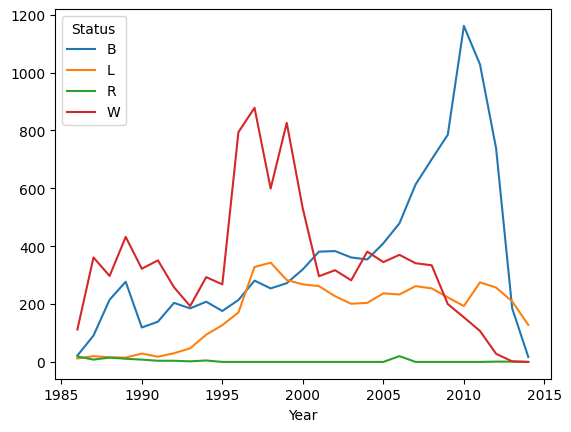

In [34]:
%matplotlib inline
by_year.plot()

---

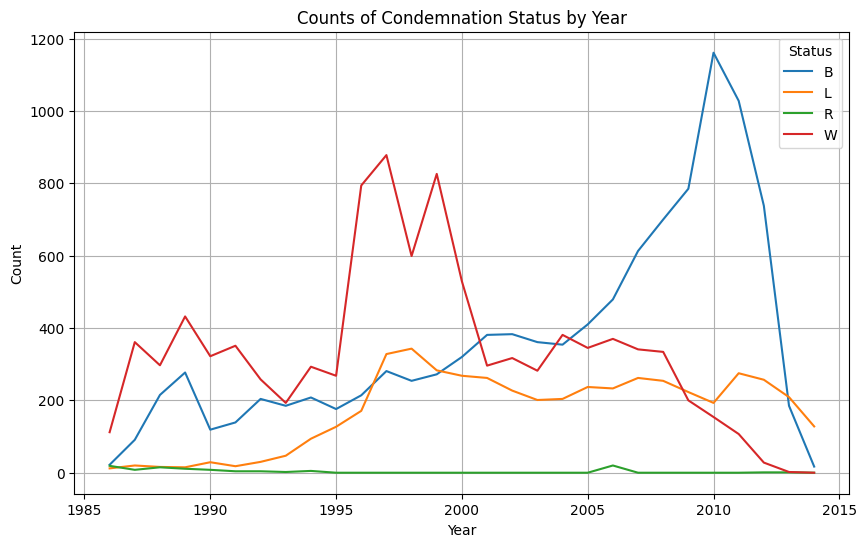

In [35]:
import matplotlib.pyplot as plt

# Plot the data
%matplotlib inline
by_year.plot(figsize=(10, 6))

# Add labels and title
plt.title("Counts of Condemnation Status by Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.grid(True)
plt.show()

import pandas as pd

# Load the dataset
url = 'https://hds5210-data.s3.amazonaws.com/meetings.csv'
meetings = pd.read_csv(url)

# Create a new column called startDate that contains just the date part of startTime
meetings['startDate'] = meetings['startTime'].str[0:10]

# Add a new column with labels "BEFORE" and "DURING"
meetings['weekLabel'] = ''
meetings.loc[(meetings['startDate'] >= '2020-02-17') &
             (meetings['startDate'] <= '2020-02-28'), 'weekLabel'] = 'BEFORE'
meetings.loc[(meetings['startDate'] >= '2020-03-16') &
             (meetings['startDate'] <= '2020-03-27'), 'weekLabel'] = 'DURING'

# Filter data to include only "BEFORE" and "DURING" rows
filtered_meetings = meetings[meetings['weekLabel'].isin(['BEFORE', 'DURING'])]

# Create a pivot table with counts of meetings hosted by each user
summary = filtered_meetings.pivot_table(
    index='userName',
   columns='weekLabel',
    values='meetingId',
    aggfunc='count',
    fill_value=0
)

# Rename columns for better clarity
summary.columns = ['Before', 'During']

# Add a column for percent change
summary['pctChange'] = ((summary['During'] - summary['Before']) / summary['Before']).fillna(0).replace([float('inf'), -float('inf')], 0).round(2)

# PART 2 - Video Conference Usage

In this next part of the assignment, we'll be looking at how video conference usage changed during the beginning of COVID-19.  This real data.  Please don't judge anyone based on the information here.  ;)  The data is in the `https://hds5210-data.s3.amazonaws.com/meetings.csv` file.

For the assignment, I want you to compare (by person) the number of meetings hosted by each user for the last two weeks of February and the last two weeks of March.  This might be a little complicated to think through HOW to do that, so the steps below are one approach.

1. Create a new column called startDate that contains just the day part of the startTime column in the data.  You can do that using datetime functions if you want, but you'll notice that the date in this file is a string formatted YYYY-MM-DD-HH:mm:ss, so it's probably easier just to pull out the first 10 characters of the string instead.  `meetings['startTime'].str[0:10]`
2. Create another new column.  This one should contain a label like "BEFORE" for the week 2/17 - 2/28 and "DURING" for the week of 3/16 - 3/27.  A hand tip on this is that you can set values for some rows in a data frame using `meetings.loc[row_filter,'Column Name'] = 'Value'` if you've created a `row_filter` as we discussed in prior weeks.
3. From here, using `pivot_table()` is one good way to summarize the information.

**FINAL RESULT**

For a final result, I'd like you to produce a data frame named **summary** that contains:
* One ROW for each userName.  The userName can either be the row index or a column in the data frame.
* One COLUMN for the "BEFORE" week and one COLUMN for the "DURING" week.  Name those columns 'Before' and 'During'.
* One more calculated column that shows the percent increase from BEFORE to DURING.  Name that column 'pctChange'.


In [36]:
import pandas as pd
meetings = pd.read_csv('meetings.csv')

In [37]:
summary = meetings.columns

In [38]:
# Extract the date part (YYYY-MM-DD) from the startTime column
meetings['StartDate'] = meetings['startTime'].str[0:10]

# Define a function to label rows based on specific date ranges
def vconf(conf_date):
    year = conf_date[0:4]  # Extract the year from the date (not used in logic here)
    month = conf_date[5:7]  # Extract the month
    date = conf_date[8:]  # Extract the day
    # Label as "Before" if the date falls between 2/17 and 2/28
    if month == '02' and 17 <= int(date) <= 28:
        return "Before"
    # Label as "During" if the date falls between 3/16 and 3/27
    if month == '03' and 16 <= int(date) <= 27:
        return "During"
    # Return the original date if it doesn't fall into the defined ranges
    return conf_date

# Apply the vconf function to the StartDate column to create a new column
meetings['NewColumn'] = meetings['StartDate'].apply(vconf)

# Filter the DataFrame to keep only rows labeled as "Before" or "During"
values = ['Before', 'During']
dropped_user = meetings[meetings.NewColumn.isin(values) == True]

# Create a pivot table to count meetings for each user during "Before" and "During" weeks
sum = dropped_user.pivot_table(index='userName', columns='NewColumn', aggfunc='size')

# Reset the index of the pivot table to make userName a column instead of the index
meetings_upv = sum.reset_index()

# Expected output or further steps can be continued from here (e.g., adding pctChange column)

In [39]:
# Fill any missing values (NaN) in the 'During' column with 0
meetings_upv['During'] = meetings_upv['During'].fillna(0)
# This ensures that users with no meetings during the "During" period have their meeting count as 0 instead of NaN.

# Calculate the percentage change from "Before" to "During" for each user
meetings_upv['pctChange'] = (meetings_upv['During'] - meetings_upv['Before']) / meetings_upv['Before']
# This formula computes the relative increase or decrease in meeting counts.
# It might result in infinite values if 'Before' is 0, which needs handling.

# Assign the processed DataFrame to the summary variable (likely the final output)
summary = meetings_upv
# The `summary` variable now contains the pivot table with "Before," "During," and "pctChange" columns.

---

In [40]:
assert(len(summary) == 22)

In [41]:
assert(summary['pctChange'].mean().round(2) == 0.92)



---



## Submitting Your Work

Submit as usual
